## Import

In [1]:
# %conda install -c conda-forge albumentations

In [2]:
# !pip install wandb

In [3]:
import glob
import os
import random
import warnings

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from albumentations.pytorch.transforms import ToTensorV2
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

import wandb

warnings.filterwarnings(action='ignore')

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('mps') if torch.has_mps else torch.device('cpu')

## Hyperparameter Setting

In [5]:
CFG = {
    'IMG_SIZE': 224,
    'EPOCHS': 40,
    'LEARNING_RATE': 5e-4,
    'BATCH_SIZE': 32,
    'SEED': 41,
    'MODEL_NAME': 'resnext50_32x4d_swsl'
}

In [6]:
%wandb login

In [7]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Dacon-Dobae",

    # track hyperparameters and run metadata
    config={
        "learning_rate": CFG['LEARNING_RATE'],
        "architecture": CFG['MODEL_NAME'],
        "epochs": CFG['EPOCHS'],
    }
)

wandb: Currently logged in as: brainer. Use `wandb login --relogin` to force relogin


## Fixed RandomSeed

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(CFG['SEED'])  # Seed 고정

## Data Pre-processing

In [9]:
all_img_list = glob.glob('./train/*/*')

In [10]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x: str(x).split('/')[2])

In [11]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

## Label-Encoding

In [12]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

## CustomDataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_path_list[index]

        image = cv2.imread(img_path)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

In [14]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, always_apply=False, p=0.5),
    A.RandomContrast(limit=0.2, always_apply=False, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False,
                p=1.0),
    A.Rotate(limit=40, p=0.5),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, always_apply=False, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
    A.RandomContrast(limit=0.2, always_apply=False, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False,
                p=1.0),
    A.Rotate(limit=40, p=0.5),
    ToTensorV2()

])

In [15]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Train

In [16]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    best_score = 0
    best_model = None

    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(imgs)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        wandb.log({"train_loss": _train_loss, "val_loss": _val_loss, "val_score": _val_score})
        print(
            f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')

        torch.save(model.state_dict(), f"{CFG['MODEL_NAME']} epoch {epoch} val_score {_val_score:.5f}.pt")

        if scheduler is not None:
            scheduler.step(_val_score)

        if best_score < _val_score:
            best_score = _val_score
            best_model = model

    return best_model

In [17]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            pred = model(imgs)

            loss = criterion(pred, labels)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()

            val_loss.append(loss.item())

        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')

    return _val_loss, _val_score

## Run!!

In [18]:
model = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', CFG['MODEL_NAME'])
model.eval()
optimizer = torch.optim.NAdam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,
                                                       threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Using cache found in /Users/brainer/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.82560] Val Loss : [2.61457] Val Weighted F1 Score : [0.44731]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [2], Train Loss : [1.04552] Val Loss : [1.21062] Val Weighted F1 Score : [0.61323]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.86364] Val Loss : [1.28357] Val Weighted F1 Score : [0.62487]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.75131] Val Loss : [1.11102] Val Weighted F1 Score : [0.67802]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.68978] Val Loss : [1.31390] Val Weighted F1 Score : [0.62857]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.59814] Val Loss : [2.05334] Val Weighted F1 Score : [0.49421]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.58241] Val Loss : [1.02756] Val Weighted F1 Score : [0.69568]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.48928] Val Loss : [1.30375] Val Weighted F1 Score : [0.64675]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.48148] Val Loss : [1.55200] Val Weighted F1 Score : [0.61652]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.44350] Val Loss : [1.37584] Val Weighted F1 Score : [0.64374]
Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.27880] Val Loss : [0.90125] Val Weighted F1 Score : [0.77158]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.16017] Val Loss : [0.85249] Val Weighted F1 Score : [0.78650]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.15139] Val Loss : [0.92127] Val Weighted F1 Score : [0.77525]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.12063] Val Loss : [0.93945] Val Weighted F1 Score : [0.76636]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.11767] Val Loss : [1.04938] Val Weighted F1 Score : [0.75044]
Epoch 00015: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.06708] Val Loss : [0.84021] Val Weighted F1 Score : [0.79350]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.05787] Val Loss : [0.79001] Val Weighted F1 Score : [0.80782]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.04406] Val Loss : [0.85853] Val Weighted F1 Score : [0.79738]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.04105] Val Loss : [0.86757] Val Weighted F1 Score : [0.79971]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.04007] Val Loss : [0.92895] Val Weighted F1 Score : [0.78666]
Epoch 00020: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.03120] Val Loss : [0.89427] Val Weighted F1 Score : [0.79574]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.02620] Val Loss : [0.92089] Val Weighted F1 Score : [0.79751]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.02040] Val Loss : [0.91660] Val Weighted F1 Score : [0.79348]
Epoch 00023: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.01846] Val Loss : [0.84369] Val Weighted F1 Score : [0.80505]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.02131] Val Loss : [0.84396] Val Weighted F1 Score : [0.81492]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.01490] Val Loss : [0.85764] Val Weighted F1 Score : [0.80589]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.01400] Val Loss : [0.85821] Val Weighted F1 Score : [0.81223]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.01107] Val Loss : [0.90663] Val Weighted F1 Score : [0.80266]
Epoch 00028: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.01169] Val Loss : [0.86189] Val Weighted F1 Score : [0.81177]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.01676] Val Loss : [0.89156] Val Weighted F1 Score : [0.80518]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.01337] Val Loss : [0.85553] Val Weighted F1 Score : [0.80949]
Epoch 00031: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.01139] Val Loss : [0.89698] Val Weighted F1 Score : [0.80697]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.01394] Val Loss : [0.90644] Val Weighted F1 Score : [0.79959]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.00590] Val Loss : [0.87059] Val Weighted F1 Score : [0.80298]
Epoch 00034: reducing learning rate of group 0 to 3.9063e-06.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.00696] Val Loss : [0.87397] Val Weighted F1 Score : [0.80648]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.00962] Val Loss : [0.88048] Val Weighted F1 Score : [0.81150]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.00728] Val Loss : [0.94433] Val Weighted F1 Score : [0.80159]
Epoch 00037: reducing learning rate of group 0 to 1.9531e-06.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.00657] Val Loss : [0.86009] Val Weighted F1 Score : [0.80544]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.00888] Val Loss : [0.83774] Val Weighted F1 Score : [0.82307]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.00955] Val Loss : [0.88638] Val Weighted F1 Score : [0.80096]


## Inference

In [19]:
test = pd.read_csv('./test.csv')

In [20]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [21]:
label_decoder = {
    '0': '가구수정',
    '1': '걸레받이수정',
    '2': '곰팡이',
    '3': '꼬임',
    '4': '녹오염',
    '5': '들뜸',
    '6': '면불량',
    '7': '몰딩수정',
    '8': '반점',
    '9': '석고수정',
    '10': '오염',
    '11': '오타공',
    '12': '울음',
    '13': '이음부불량',
    '14': '창틀,문틀수정',
    '15': '터짐',
    '16': '틈새과다',
    '17': '피스',
    '18': '훼손'
}

In [22]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)

            pred = model(imgs)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()

    preds = le.inverse_transform(preds)
    return preds

In [23]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
torch.save(infer_model.state_dict(), f"best {CFG['MODEL_NAME']}.pt")

## Submission

In [25]:
submit = pd.read_csv('./sample_submission.csv')

In [26]:
submit['label'] = preds

In [27]:
submit['label'] = submit['label'].apply(lambda x: label_decoder[str(x)])

In [28]:
submit.to_csv(f"./{CFG['MODEL_NAME']}.csv", index=False, encoding='utf-8')

In [29]:
submit.head()

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,오염


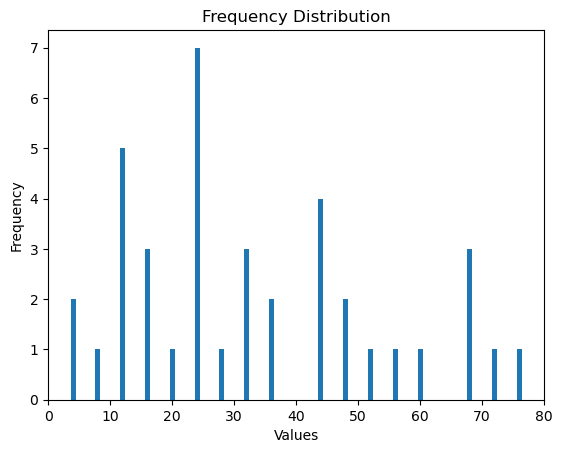

In [30]:
import matplotlib.pyplot as plt

x = [4, 8, 12, 16, 20, 24, 28, 32, 36, 44, 48, 52, 56, 60, 68, 72, 76]  # x축에 해당하는 값
y = [2, 1, 5, 3, 1, 7, 1, 3, 2, 4, 2, 1, 1, 1, 3, 1, 1]  # y축에 해당하는 값

plt.bar(x, y)  # 막대 그래프 그리기
plt.xlabel('Values')  # x축 레이블 설정
plt.ylabel('Frequency')  # y축 레이블 설정
plt.title('Frequency Distribution')  # 그래프 제목 설정
plt.show()  # 그래프 출력


In [31]:
data = [4, 8, 12, 16, 20, 24, 28, 32, 36, 44, 48, 52, 56, 60, 68, 72, 76]

q1 = np.percentile(data, 25)  # 제1사분위수(Q1) 계산
q3 = np.percentile(data, 75)  # 제3사분위수(Q3) 계산

print("Q1:", q1)
print("Q3:", q3)


Q1: 20.0
Q3: 56.0


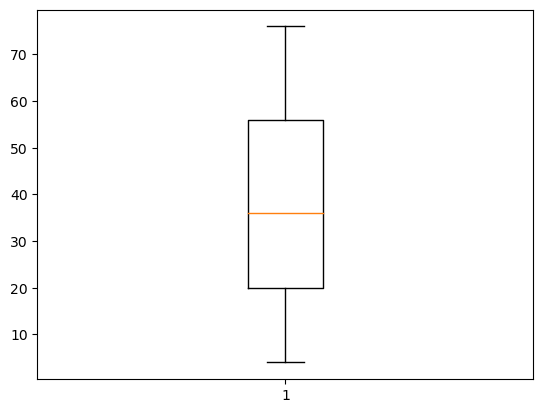

In [32]:
import matplotlib.pyplot as plt

plt.boxplot(x)
plt.show()

In [33]:
import scipy.stats as stats

# 예를 들어, 이 데이터셋을 기반으로 A, B, C, D 네 개의 그룹이 있다고 가정하겠습니다.
# 이 그룹별로 데이터를 나누어서 리스트로 저장합니다.

group_A = [4, 8, 12, 16, 20, 24, 28, 32]
group_B = [36, 44, 48, 52, 56, 60]
group_C = [68, 72, 76]
group_D = [3, 7]

# ANOVA 분석을 수행합니다.
fvalue, pvalue = stats.f_oneway(group_A, group_B, group_C, group_D)

print("F-value:", fvalue)
print("P-value:", pvalue)


F-value: 43.54244795034266
P-value: 1.220241868827572e-07


In [34]:
# 피어슨 상관계수(Pearson correlation coefficient)를 계산합니다.
corr, pval = stats.pearsonr(x, y)

print("Correlation coefficient:", corr)


Correlation coefficient: -0.32224057459201166


In [35]:
# 피어슨 상관계수(Pearson correlation coefficient)를 계산합니다.
corr, pval = stats.pearsonr(x, y)

print("Correlation coefficient:", corr)
print("P-value:", pval)


Correlation coefficient: -0.32224057459201166
P-value: 0.2071615817788261


In [36]:
# 3사분위수 계산
q3 = np.percentile(x, 75)

# 중간값(median)과 3사분위수(upper quartile) 비교
if np.median(data) < 48 <= q3:
    print("48 is between median and upper quartile.")
    print("It is in the top 25% of the dataset.")
else:
    print("48 is not in the top 25% of the dataset.")

48 is between median and upper quartile.
It is in the top 25% of the dataset.


In [37]:
wandb.finish()

train_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▃▆▂▃▄▃▁▁▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_score,▁▄▄▅▄▂▆▅▄▅▇▇▇▇▇▇███▇▇█▇█████████████████
train_loss,0.00955
val_loss,0.88638
val_score,0.80096


In [38]:
submit = pd.read_csv(f"{CFG['MODEL_NAME']}.csv")

submit['label'] = submit['label'].apply(lambda x: label_decoder[str(x)])

KeyError: '훼손'

In [ ]:
submit.to_csv("semi-supervised-ImageNet1K-models-10epoch.csv", index=False)